In [6]:
%load_ext autoreload
%autoreload 2

In [54]:
import pandas as pd
import os
from wordcloud import WordCloud
import re
from pandarallel import pandarallel
from helpers import clean_puncnum, clean_text
pandarallel.initialize()
import nltk
import matplotlib.pyplot as plt
nltk.download('stopwords')

INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


[nltk_data] Downloading package stopwords to /home/msds-
[nltk_data]     pt2025b/jco/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
df = pd.read_csv('covid.csv')
df.head()

,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,Sponsor/Collaborators,...,Other IDs,Start Date,Primary Completion Date,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL
0,1,NCT04785898,Diagnostic Performance of the ID Now™ COVID-19...,COVID-IDNow,"Active, not recruiting",No Results Available,Covid19,Diagnostic Test: ID Now™ COVID-19 Screening Test,Evaluate the diagnostic performance of the ID ...,Groupe Hospitalier Paris Saint Joseph,...,COVID-IDNow,"November 9, 2020","December 22, 2020","April 30, 2021","March 8, 2021",NaN,"March 8, 2021","Groupe Hospitalier Paris Saint-Joseph, Paris, ...",NaN,https://ClinicalTrials.gov/show/NCT04785898
1,2,NCT04595136,Study to Evaluate the Efficacy of COVID19-0001...,COVID-19,Not yet recruiting,No Results Available,SARS-CoV-2 Infection,Drug: Drug COVID19-0001-USR|Drug: normal saline,Change on viral load results from baseline aft...,United Medical Specialties,...,COVID19-0001-USR,"November 2, 2020","December 15, 2020","January 29, 2021","October 20, 2020",NaN,"October 20, 2020","Cimedical, Barranquilla, Atlantico, Colombia",NaN,https://ClinicalTrials.gov/show/NCT04595136
2,3,NCT04395482,Lung CT Scan Analysis of SARS-CoV2 Induced Lun...,TAC-COVID19,Recruiting,No Results Available,covid19,Other: Lung CT scan analysis in COVID-19 patients,A qualitative analysis of parenchymal lung dam...,University of Milano Bicocca,...,TAC-COVID19,"May 7, 2020","June 15, 2021","June 15, 2021","May 20, 2020",NaN,"November 9, 2020","Ospedale Papa Giovanni XXIII, Bergamo, Italy|P...",NaN,https://ClinicalTrials.gov/show/NCT04395482
3,4,NCT04416061,The Role of a Private Hospital in Hong Kong Am...,COVID-19,"Active, not recruiting",No Results Available,COVID,Diagnostic Test: COVID 19 Diagnostic Test,Proportion of asymptomatic subjects|Proportion...,Hong Kong Sanatorium & Hospital,...,RC-2020-08,"May 25, 2020","July 31, 2020","August 31, 2020","June 4, 2020",NaN,"June 4, 2020","Hong Kong Sanatorium & Hospital, Hong Kong, Ho...",NaN,https://ClinicalTrials.gov/show/NCT04416061
4,5,NCT04395924,Maternal-foetal Transmission of SARS-Cov-2,TMF-COVID-19,Recruiting,No Results Available,Maternal Fetal Infection Transmission|COVID-19...,Diagnostic Test: Diagnosis of SARS-Cov2 by RT-...,COVID-19 by positive PCR in cord blood and / o...,Centre Hospitalier Régional d'Orléans|Centre d...,...,CHRO-2020-10,"May 5, 2020",May 2021,May 2021,"May 20, 2020",NaN,"June 4, 2020","CHR Orléans, Orléans, France",NaN,https://ClinicalTrials.gov/show/NCT04395924


In [55]:
df['Title Processed'] = df['Title'].parallel_apply(clean_puncnum)
df['Title Processed'] = df['Title Processed'].parallel_apply(clean_text)
df['Conditions Processed'] = df['Conditions'].parallel_apply(clean_puncnum)
df['Conditions Processed'] = df['Conditions Processed'].parallel_apply(clean_text)

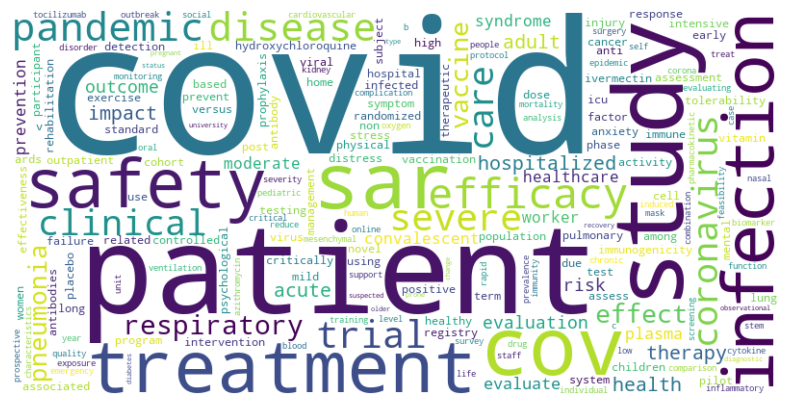

In [34]:
corpus = ' '.join(df['Title Processed'])
# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', collocations = False).generate(corpus)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [77]:
import gensim
from gensim.utils import simple_preprocess

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'sars', 'cov', 'covid', 'study', 'patients', 'patient'])
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]


In [95]:
data = df['Conditions Processed'].values.tolist()
words = list(sent_to_words(data))
words = remove_stopwords(words)

In [96]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(words)
# Create Corpus
texts = words
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

In [100]:
from pprint import pprint
# number of topics
num_topics = 4
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.078*"infection" + 0.035*"virus" + 0.033*"corona" + 0.022*"respiratory" + '
  '0.022*"ards" + 0.018*"syndrome" + 0.018*"acute" + 0.016*"disease" + '
  '0.013*"healthy" + 0.013*"distress"'),
 (1,
  '0.036*"infection" + 0.027*"disorder" + 0.024*"anxiety" + 0.022*"stress" + '
  '0.020*"depression" + 0.020*"disease" + 0.020*"respiratory" + '
  '0.014*"diabetes" + 0.012*"severe" + 0.011*"diseases"'),
 (2,
  '0.073*"coronavirus" + 0.056*"infection" + 0.050*"respiratory" + '
  '0.049*"acute" + 0.036*"syndrome" + 0.025*"disease" + 0.024*"failure" + '
  '0.022*"cancer" + 0.021*"pneumonia" + 0.016*"severe"'),
 (3,
  '0.052*"coronavirus" + 0.046*"infection" + 0.041*"pneumonia" + '
  '0.022*"respiratory" + 0.022*"disease" + 0.019*"syndrome" + 0.018*"virus" + '
  '0.017*"infections" + 0.016*"health" + 0.016*"viral"')]


In [101]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string
nltk.download('punkt')

table = str.maketrans('', '', string.punctuation)

def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    tokens = [word.translate(table) for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

#Preprocess documents
preprocessed_documents = [preprocess_text(doc) for doc in df['Title Processed']]

# Calculate TF-IDF
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(preprocessed_documents)

# Get top keywords
feature_names = vectorizer.get_feature_names_out()
keywords_info = {}

for i, doc in enumerate(preprocessed_documents):
    feature_index = tfidf_matrix[i,:].nonzero()[1]
    for idx in feature_index:
        keyword = feature_names[idx]
        if keyword not in keywords_info:
            keywords_info[keyword] = {'score': 0, 'appearances': 0}
        keywords_info[keyword]['score'] += tfidf_matrix[i, idx]
        keywords_info[keyword]['appearances'] += 1

# Sort keywords by score
sorted_keywords = sorted(keywords_info.items(), key=lambda x: x[1]['score'], reverse=True)

# Print top keywords along with their document frequency
sorted_keywords[:100]

[nltk_data] Downloading package punkt to /home/msds-
[nltk_data]     pt2025b/jco/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


[('treatment', {'score': 134.32519939842578, 'appearances': 552}),
 ('infection', {'score': 117.3526058651395, 'appearances': 501}),
 ('safety', {'score': 111.56638478198603, 'appearances': 502}),
 ('efficacy', {'score': 104.1982295065996, 'appearances': 436}),
 ('pandemic', {'score': 88.05482918793231, 'appearances': 372}),
 ('severe', {'score': 86.9705957363848, 'appearances': 327}),
 ('disease', {'score': 84.99380519522441, 'appearances': 338}),
 ('trial', {'score': 80.60906705026201, 'appearances': 316}),
 ('coronavirus', {'score': 76.62066885951317, 'appearances': 294}),
 ('clinical', {'score': 75.47826125874505, 'appearances': 294}),
 ('care', {'score': 72.14129169570475, 'appearances': 290}),
 ('respiratory', {'score': 69.82746444071597, 'appearances': 281}),
 ('pneumonia', {'score': 69.12133457724242, 'appearances': 240}),
 ('hospitalized', {'score': 68.92147651784254, 'appearances': 239}),
 ('therapy', {'score': 65.49656791267967, 'appearances': 226}),
 ('plasma', {'score': 64

In [102]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(str(num_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, str(num_topics) +'.html')
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.076195  0.049843       1        1  30.717319
0     -0.029248 -0.108450       2        1  23.575170
1      0.118589  0.010599       3        1  23.312595
3     -0.013146  0.048008       4        1  22.394915, topic_info=            Term        Freq       Total Category  logprob  loglift
19   coronavirus  562.000000  562.000000  Default  30.0000  30.0000
47        corona  181.000000  181.000000  Default  29.0000  29.0000
64     pneumonia  284.000000  284.000000  Default  28.0000  28.0000
20       anxiety  151.000000  151.000000  Default  27.0000  27.0000
48         virus  237.000000  237.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
93          care   18.882472   70.424109   Topic4  -5.1824   0.1800
155     distress   24.087329  153.241580   Topic4  -4.9389  -0.3540
39      diseases   21.881051  125.146090   Topic4  -5.0350  -0.2475
22    depression   20.944817  113.434711   Topic4  -5.0787  -0.1930
184       stress   21.292587  151.902183   Topic4  -5.0622  -0.4685

[301 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
1423      4  0.849439       abuse
37        1  0.627023       acute
37        2  0.171258       acute
37        3  0.077342       acute
37        4  0.124300       acute
...     ...       ...         ...
48        2  0.513995       virus
48        3  0.042131       virus
48        4  0.252784       virus
559       1  0.141036  volunteers
559       2  0.775698  volunteers

[519 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 2, 4])